In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random


map = "RL_project_data/project_data/map_3.dat"

enemies = "RL_project_data/project_data/map_3.dat"




def load_data(map_file, enemies_file):
    map_data = np.loadtxt(map_file)
    map_shape = map_data.shape
    start_position = (map_shape[0]-2, 1)
    goal_position = (1, map_shape[0]-2)

    enemies_data = np.loadtxt(enemies_file)
    if enemies_data.ndim == 1:  # if there's only one enemy
        enemies_data = np.reshape(enemies_data, (1, -1))  # reshape into a 2D array

    mm = [] # Stores MMs coordinates
    for i in range(len(enemies_data)):
        if enemies_data[i, -1] == 1: # Only MMs
            mm_coord = (int(enemies_data[i, 0] - 1), int(enemies_data[i, 1] - 1))
            # Find the rightmost position the enemy can move to as only the leftmost is given
            mm_rightmost = mm_coord[1]
            while map_data[mm_coord[0] + 1, mm_rightmost + 1] in [2, 3]:
                mm_rightmost += 1
            # Define the enemy's movement range and initial position
            mm_range = (mm_coord[1], mm_rightmost)
            mm_pos = (mm_coord[0], random.randint(*mm_range))
            mm.append((mm_pos, mm_range))
            
            print(mm)
            # Final coordinates displayed as: (y, x), (leftmost_x, rightmost_x)
    return map_data, mm, start_position, goal_position


In [2]:


class environment:
    def __init__(self, map_data, start_position, goal_position, mm, p_mm):
        self.map_data = map_data
        self.position = start_position 
        self.start_position = start_position
        self.goal = goal_position
        self.done = False
        self.mm = mm
        self.p_mm = p_mm
        self.energy = 0 
        self.initial_mm = mm.copy()
        self.path = []
        self.highest_position = start_position[0]  # Track the highest position Hubert has reached


    def reset(self):
        self.position = self.start_position
        self.mm = self.initial_mm.copy()
        self.energy = 0
        self.done = False
        self.path = [self.start_position]
        return self.get_state()

    def get_state(self):
        return self.position
   

    def step(self, action):
        energy_before_action = self.energy
        # reward = -self.energy
        
        self.action(action)
        energy_used = self.energy - energy_before_action
        next_state = self.get_state()
        reward = -energy_used  # Reward is negative of energy used
       
        if self.done:
            reward += 1_000_000

        return next_state, reward, self.done

    def move_mm(self):
        for i, ((y, x), (leftmost_x, rightmost_x)) in enumerate(self.mm):
            new_x = x + random.choice([-1, 1])  # Move left or right
            if leftmost_x <= new_x <= rightmost_x:  # If the new position is within the corridor
                self.mm[i] = ((y, new_x), (leftmost_x, rightmost_x))  # Update the enemy's position


    def check_encounters(self):
        if self.position == self.goal: # Check if goal is reached
            self.done = True
            return
        for (enemy_coord, _) in self.mm:
            if self.position == enemy_coord:
                # If a random number is less than or equal to p_mm, Hubert encounters an enemy
                if random.random() <= self.p_mm:
                    self.position = self.start_position  # Hubert is sent back to the start
                    break


    def move(self, direction):
        self.energy += 1
        self.path.append(self.position) # Will append staring position for visualization. 
        
        # Check if Hubert can move in the desired direction
        if self.map_data[self.position[0], self.position[1] + direction] != 2:  # not solid in desired direction
            self.position = (self.position[0], self.position[1] + direction) # Move to direction
            self.check_encounters()

            if self.map_data[self.position[0] + 1, self.position[1]] == 1:  # air below
                self.position = (self.position[0] + 1, self.position[1]) # Fall 1 unit down
                self.check_encounters()
                
                if self.map_data[self.position[0] + 1, self.position[1]] == 1:  # air below
                    if self.map_data[self.position[0] + 1, self.position[1] + direction] != 2:  # not solid in desired direction
                        self.position = (self.position[0], self.position[1] + direction) # Move to direction
                        self.check_encounters()
                        
                        if self.map_data[self.position[0] + 1, self.position[1]] == 1:  # air below
                             self.position = (self.position[0] + 1, self.position[1]) # Fall 1 unit down
                             self.check_encounters()
                    else:
                        self.position = (self.position[0] + 1, self.position[1]) # Fall 1 unit down
                        self.check_encounters()


    def jump(self):
        self.path.append(self.position) # Will append staring position for visualization. 
        # If Hubert is standing on the ground
        if self.map_data[self.position[0] + 1, self.position[1]] in [2, 3]:  # solid or semisolid
            self.energy += 5
            # Jump up to 2 units or as much as headroom allows
            if self.map_data[self.position[0] - 1, self.position[1]] != 2:  # not solid above
                self.position = (self.position[0] - 1, self.position[1]) # Move up
                self.check_encounters()
            
                if self.map_data[self.position[0] - 1, self.position[1]] != 2:  # not solid above
                    self.position = (self.position[0] - 1, self.position[1]) # Move up
                    self.check_encounters()
            
        else:  # no ground under feet
            if self.map_data[self.position[0] + 1, self.position[1]] == 1:  # air below
                self.position = (self.position[0] + 1, self.position[1]) # Fall 1 unit down
                self.check_encounters()
                
                if self.map_data[self.position[0] + 1, self.position[1]] == 1:  # air below
                    self.position = (self.position[0] + 1, self.position[1]) # Fall 1 unit down
                    self.check_encounters()

    
    def action(self, action):
        self.move_mm()
        if action == 0: # Left
            self.move(1)
        elif action == 1: # Right
            self.move(-1)
        elif action == 2: # Jump
            self.jump()
        else:
            raise Exception("\nInvalid action input")



In [5]:

# Create an environment
map_data, mm, start_position, goal_position = load_data(map, enemies)
env = environment(map_data, start_position, goal_position, mm, p_mm=0)



class QLearningAgent:
    def __init__(self, env, learning_rate=0.4, discount_factor=0.95, exploration_rate=0.1, exploration_decay_rate=0.95):
        self.env = env
        self.lr = learning_rate
        self.df = discount_factor
        self.er = exploration_rate
        self.edr = exploration_decay_rate
        
        # Initialize the Q-table to small random values
        self.q_table = np.random.uniform(low=-1, high=1, size=(env.map_data.shape[0], env.map_data.shape[1], 3))

    def choose_action(self, state):
        # Epsilon-greedy action selection
        if random.random() < self.er:
            return random.choice([0, 1, 2])  # choose a random action
        else:
            return self.get_best_action(state)

    def update_q_table(self, state, action, reward, new_state):
        self.q_table[state[0], state[1], action] = (1 - self.lr) * self.q_table[state[0], state[1], action] + \
            self.lr * (reward + self.df * np.max(self.q_table[new_state[0], new_state[1]]))

    def train(self, episodes):
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                new_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, new_state)
                state = new_state
                
            if episode == 1 or episode == 5 or episode % 50 == 0:
                print(f"Finished episode {episode} at position: {env.position}, Exploration rate {self.er}")
                display(map_data, mm, env.position, env.goal, env.path)
                
            # Decrease the exploration rate
            self.er *= self.edr


    def get_best_action(self, state):
        q1 = (self.q_table[state[0], state[1]])[0]
        q2 = (self.q_table[state[0], state[1]])[1]
        q3 = (self.q_table[state[0], state[1]])[2]
    
        if q1 == q2 and q2 == q3:
            return random.choice([0, 1, 2])
        elif q1 == q2 and q1 > q3:
            return random.choice([0, 1])
        elif q1 == q3 and q1 > q2:
            return random.choice([0, 2])
        elif q2 == q3 and q2 > q1:
            return random.choice([1, 2])
        else:
            return np.argmax(self.q_table[state[0], state[1]])
        


In [6]:


def display(map_data, mm, hubert_pos, goal_position, path):
    # Create a custom color map
    cmap = plt.cm.colors.ListedColormap(['white', 'black', 'blue'])

    plt.figure(figsize=(5, 4))
    plt.imshow(map_data, cmap=cmap, origin='upper')
    

    # Display the enemies
    for ((enemy_y, enemy_x), _) in mm:
        plt.scatter(enemy_x, enemy_y, color='red', s=50)  # s is the size of the point


    # Display Hubert's path
    path = path[-500:]
    if path:
        path_y, path_x = zip(*path)  # Separate the x and y coordinates
        plt.plot(path_x, path_y, color='grey', linestyle='-', linewidth=1)
        
    # Display Hubert's current position
    plt.scatter(hubert_pos[1], hubert_pos[0], color='green', s=50)
    plt.scatter(goal_position[1], goal_position[0], color='green', marker="*", s=60)
    plt.show()




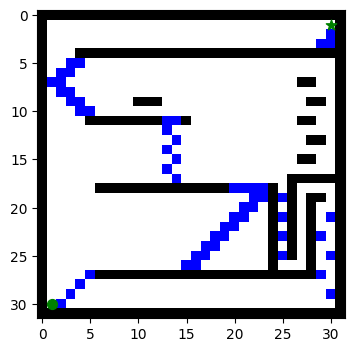

Finished episode 0 at position: (1, 30), Exploration rate 0.1


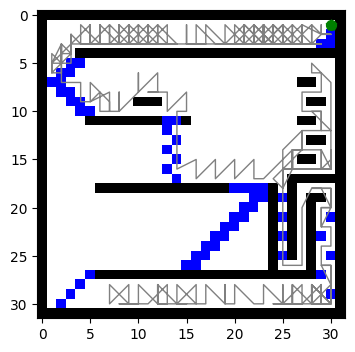

Finished episode 1 at position: (1, 30), Exploration rate 0.095


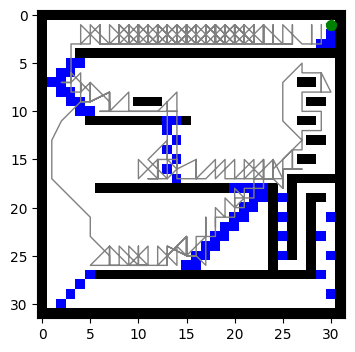

Finished episode 5 at position: (1, 30), Exploration rate 0.07737809374999999


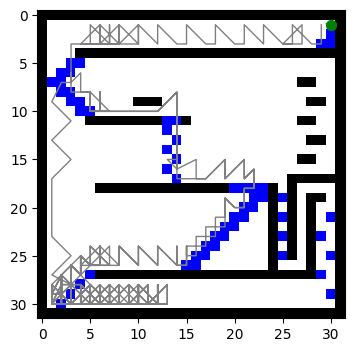

In [7]:


# Create a Q-learning agent
agent = QLearningAgent(env)
display(map_data, mm, env.position, env.goal, env.path)
# Train the agent
agent.train(10)


Running count 10,000,000


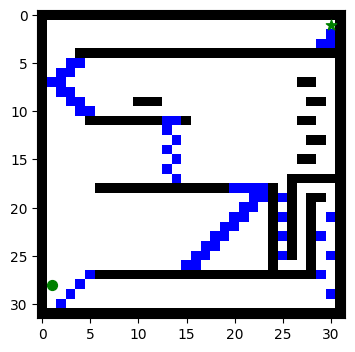

In [8]:

count = 0
# Test the trained agent
state = env.reset()
done = False
while not done:
    action = agent.get_best_action(state)
    new_state, reward, done = env.step(action)
    state = new_state
    count += 1
    if count % 10_000_000 == 0:
        print(f"Running count {count:,}")
        if count == 10_000_000:
            done = True


display(map_data, mm, env.position, env.goal, env.path)
